# Problem understanding and overall proposed solution

Given a dataset of monthly metrics for a number of clients, predict whether they will apply or not to a credit line (loan).

The dataset contains two CSV files:
* customers.csv contains the monthly metric about each customer.
* credit_applications.csv contains whether they have applied for a credit on that month and how many times.

## Problem understanding

The problem is a classification problem where given a set of metrics $X $ one whishes to classify whether the customer will apply for a loan on the next month (i.e $y(c, m+1)$).

The training set will then contain $M=N_{customer}*N_{month}$ entries and for each entry will have N features (X is a matrix of M rows and N columns)

$$ X = {x(c, m) } = { [x_0(c, m), ..., x_N(c, m)] }  \forall c, m$$

To treat this problem as a classification problem one needs to forward the credit application into the future in order to create a consistent set of training data: at month m we know the data of $x(c, m)$ but we need to classify the future $y(c, m+1)$.

## Tech choice

Given the data size, memory manipulation is enough and the preferred weapon is based on the python machine learning ecosystem: ** pandas + scikit-learn + numpy + matplotlib + seaborn **


## Import datasets and basic transformations

In [1]:
import pandas as pd
import datetime as dt
import numpy as np

df_clients = pd.read_csv('customers.csv', sep=';', index_col=0)
df_credits = pd.read_csv('credit_applications.csv', sep=';', index_col=0)
df = df_clients.merge(df_credits, on=['client_nr', 'yearmonth'])
del df_clients  # save memory, not needed anymore
del df_credits  # save memory, not needed anymore
df['yearmonth'] = df.yearmonth.apply(lambda x: dt.datetime.strptime(str(x), '%Y%m'))
df['month'] = df.yearmonth.apply(lambda x: x.month)
print("Total dataset shape = {}".format(df.shape))
df.tail()

Total dataset shape = (29996, 13)


,client_nr,yearmonth,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,credit_application,nr_credit_applications,month
29991,1000,2016-04-01,2,1,605000,1,315800,131422,736422,NaN,0,0,4
29992,1000,2016-05-01,5,3,607506,2,1210000,128916,735145,NaN,0,0,5
29993,1000,2016-06-01,4,3,1211270,1,605000,127646,1338916,NaN,0,0,6
29994,1000,2016-07-01,4,2,606253,2,920000,441393,1047646,NaN,0,0,7
29995,1000,2016-08-01,3,1,1261,2,1210000,1045132,1650132,NaN,0,0,8


## Quick inspection of the dataset

* Do customer have big differences in volume or balance?
* Do customer have big differences in the changes of volume and balance?

A scatter plot for each pair of given features and how many times they applied for a credit is displayed and inspected. Spoiler alert: no magic feature is given (that would provide a great correlation/insight on the credit application). 

Also, one can see  highly correlated variables (e.g. nr_credit_trx, nr_total_trx) that provide little added value.

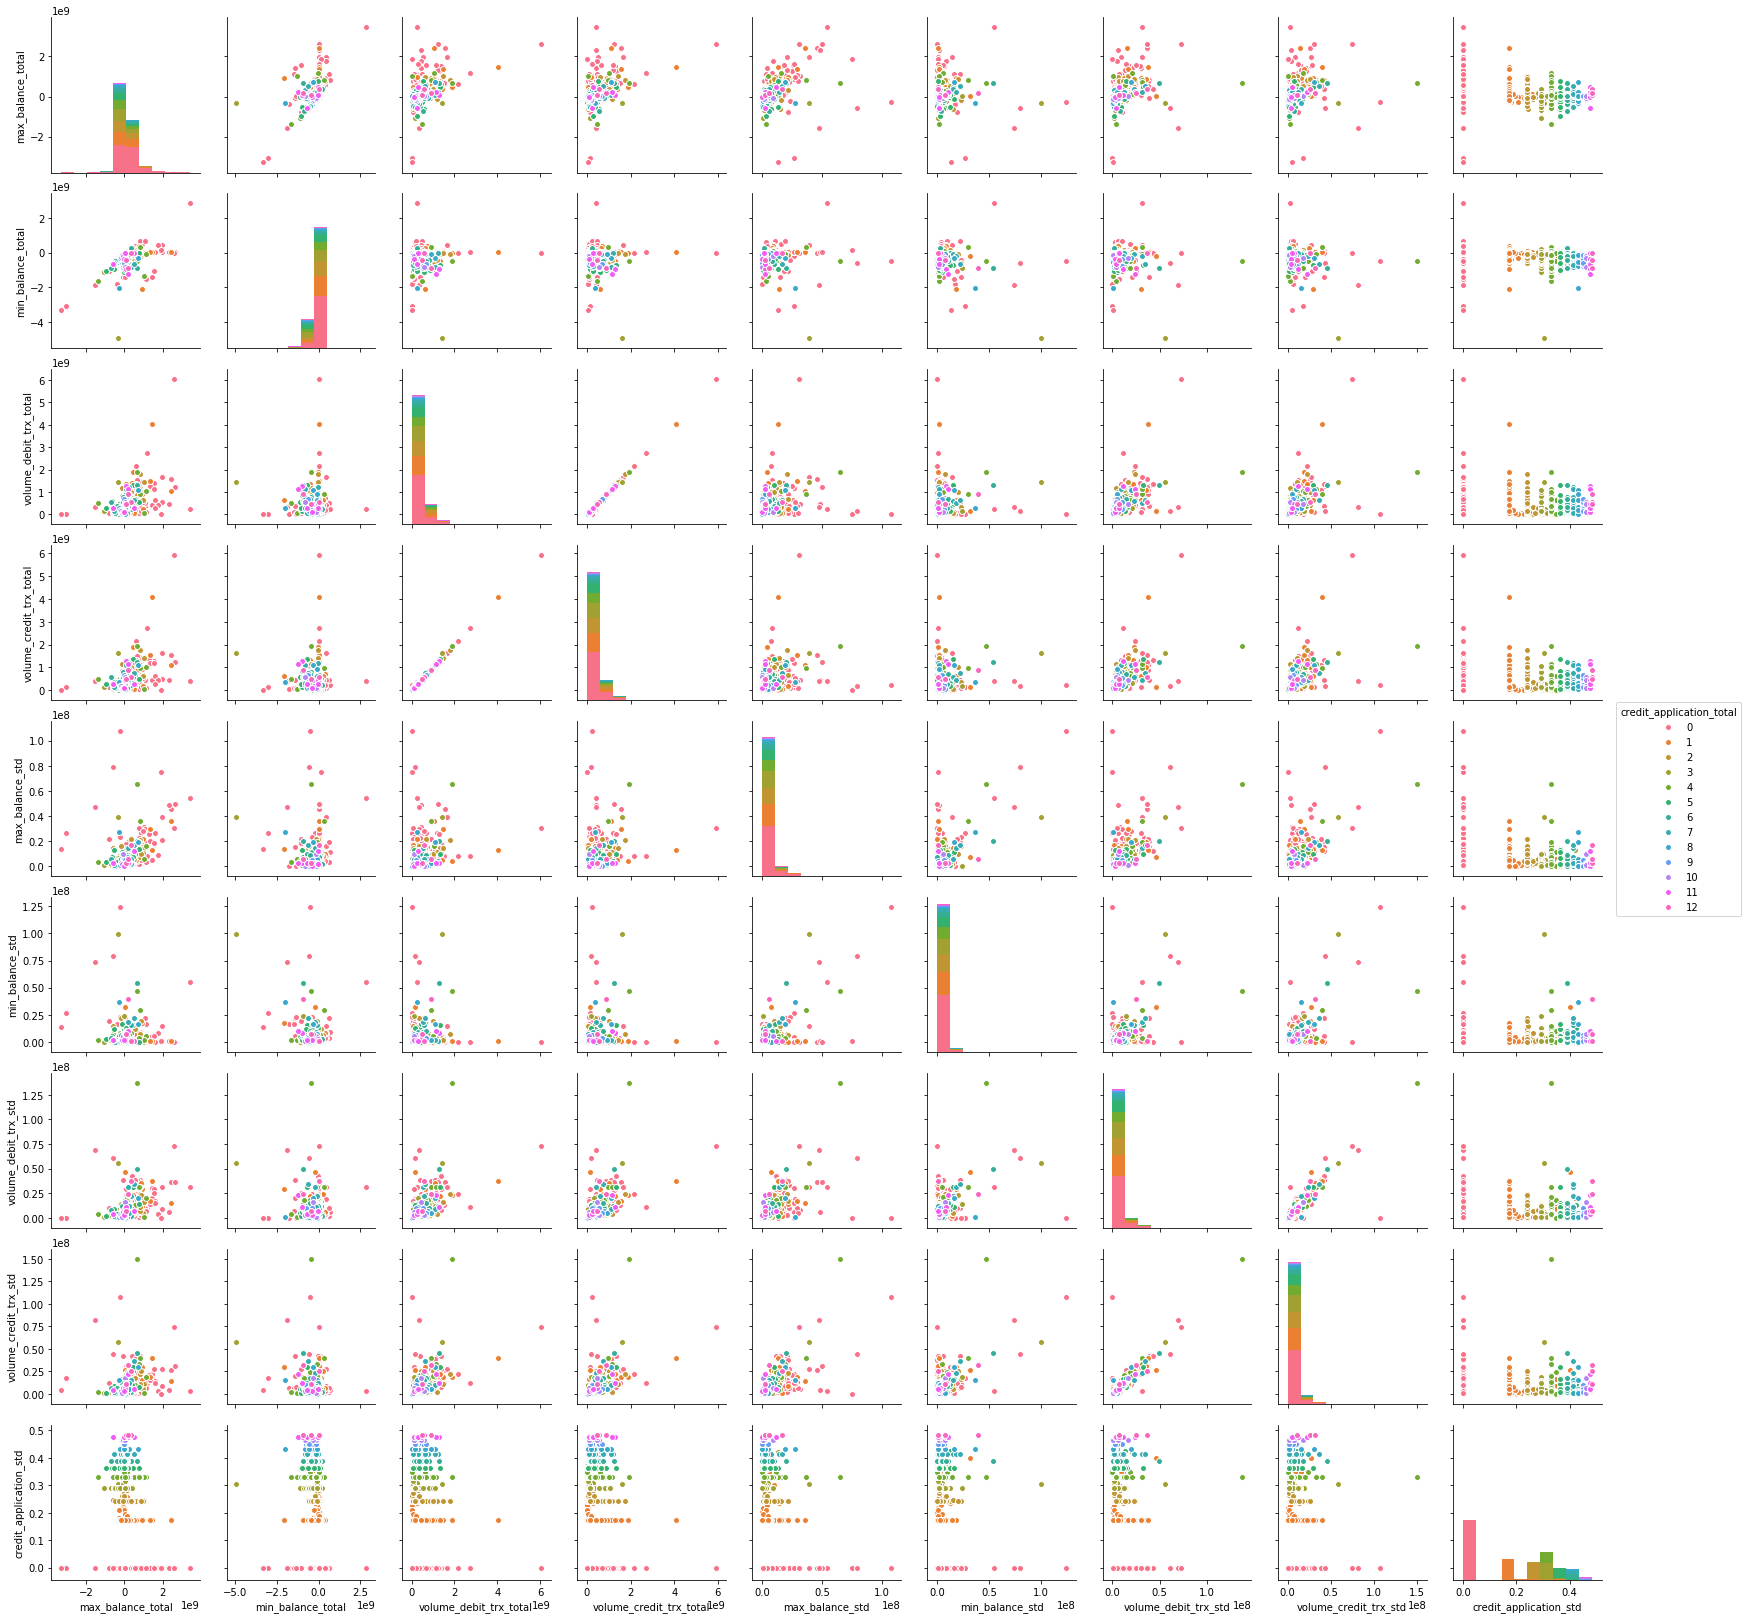

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

def inspect(df, metrics, params, hue_is, save_plot=True):
    """
    Scatter plots of all features against chosen variable
    """
    agg_df = pd.DataFrame()
    for m, f in metrics.items():
        for p in params:
            agg_df[p+'_'+m] = df.groupby('client_nr')[p].apply(f)        
    sns.pairplot(agg_df, hue=hue_is, vars=[x for x in agg_df.columns if x != hue_is])
    if save_plot:
        plt.savefig('inspect.jpg')
    plt.show()

metrics = {'total':np.sum, 'std':np.std}
params = ['max_balance', 'min_balance', 'volume_debit_trx', 'volume_credit_trx', 'credit_application']
inspect(df, metrics, params, 'credit_application_total', save_plot=False)

## Feature engineering

In reality one should acquire relevant domain knowledge, either by teaming up with experts or researching, in order to be able to come up with good features (i.e. features or variables that would explain certain aspects of the classification or prediction).

The following metrics are computed that could help the decision:

* Total number of applications in the past
* Number of applications in the last 6 months or in the last 12 months.
* Average scaled balance difference over the last period (e.g. quarter), computed as :
$$ \mu_{\Delta B}(q) = {1 \over 3} \sum_{m \in q} {{B_{max}(m) - B_{min}(m)}  \over {\bar B_{max}}} $$

* STD of the scaled balance difference over the last period (e.g. quarter), computed as :
$$ \sigma_{\Delta B}(q) = STD({{B_{max}(m) - B_{min}(m)}  \over {\bar B_{max}}}) $$

* Average scaled volume difference over the last period (e.g. quarter), computed as :
$$ \mu_{\Delta V}(q) = {1 \over 3} \sum_{m \in q} {{V_{debit}(m) - V_{credit}(m)}  \over {\bar V_{debit}}} $$

* STD of the scaled balance difference over the last period (e.g. quarter), computed as :
$$ \sigma_{\Delta V}(q) = STD({{V_{debit}(m) - V_{credit}(m)}  \over {\bar V_{debit}}}) $$

* Average CRG from the last 6 months

* Accumulated credit since last credit_application

* Regularity when applying for credits

The fact that the metrics are scaled is to consider that some customers work in the 10 MEUR scales and other are operating on the 1000MEUR scales, which is orders of magnitude different.

** Important **: also, the variable to predict should be shifted into the future 1 month: we can use up to month M-1 to predict month M. But this should be done at the very last step if one does not want to mix the future information with the feature building process. This is done with the class method `forward_feature()`

The supporting code includes two classes

* `CorrelationDataFrame` overloads the pandas dataframe assuming that it contains correlation metrics and provides help for cleaning and plotting the correlations.
* `FeatureBuilder` is a class that contains a dataframe that allows to add and modify features over a time axis

In [3]:
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

class CorrelationDataFrame(pd.DataFrame):
    """
    Overload of pandas dataframe that eases the cleanse and plotting of correlation values
    """
    def clean(self, fillna_with_mean=True):
        """
        Removes all columns and rows that only contain NaN
        """
        useless_cols = self.columns[self.sum() == 0]
        self.drop(useless_cols, axis=1, inplace=True)
        useless_rows = self.loc[self.sum(axis=1)==0].index
        self.drop(useless_rows, axis=0, inplace=True)
        if fillna_with_mean:
            self.fillna_with_mean()
        
    def fillna_with_mean(self):
        """
        Fills the nan of a column with the mean
        """
        for f in self.columns:
            self[f].fillna(self[f].mean(), inplace=True)
        
    def plot_correlation(self, min_agg_corr=0., title='Correlation of features'):
        foo = self.sum(axis=1).sort_values(ascending=False)
        good_rows = foo[foo>min_agg_corr].index  # specify a minimum threshold over the sumation of all features
        self.loc[good_rows].plot(figsize=(14,6), linestyle='', marker='.')
        plt.legend(loc="upper left", bbox_to_anchor=(1,1))
        plt.title(title)
        plt.grid()
        plt.show()
        
    def plot_tsne(self):
        tsne = TSNE(n_components=2)
        foo = tsne.fit_transform(corr_df_post.fillna(0))
        plt.figure(figsize=(10,6))
        plt.scatter(foo.transpose()[0], foo.transpose()[1])
        plt.title('TSNE representation of customer correlation with features')
        plt.show()


class FeatureBuilder():
    """
    Class that allows elegant manipulation of features
    """
    def __init__(self, df):
        self.data = pd.pivot_table(df, index=['yearmonth'], columns=['client_nr'])
    
    def add_feature(self, new_feature, name):
        new_feature.columns = pd.MultiIndex.from_product([[name], new_feature.columns])
        self.data = pd.concat([self.data, new_feature], axis=1)
       
    def __getitem__(self, i):
        return self.data[i]
    
    def forward_feature(self, name, drop_last=True):
        self.data.loc(axis=1)[name, :] = self.data.loc(axis=1)[name, :].shift(-1)
        if drop_last:
            self.data.drop(self.data.index.max(), axis=0, inplace=True) 
       
    def get_corr(self, exclude=('yearmonth'), over='credit_application', min_periods=5):
        """
        Gets customer correlation for a certain feature
        """
        apply_on = [x for x in self.data.columns.levels[0] if x not in list(exclude)+['client_nr',  over]]
        corr_df = pd.DataFrame(index=self.data.columns.levels[1], columns=apply_on)
        for v in tqdm(corr_df.columns):
            for c in corr_df.index:
                try:
                    corr_df.loc[c, v] = abs(self.data.loc(axis=1)[[v, over], c].corr(min_periods=min_periods).iloc[0, 1])
                except IndexError:
                    corr_df.loc[c, v] = np.nan
        return CorrelationDataFrame(corr_df)

    def to_df(self):
        df = self.data.stack().reset_index()
        print("Total dataset shape = {}".format(df.shape))
        return df
    
fb = FeatureBuilder(df)

# Number of applications so far
foo = fb['credit_application'].fillna(0).cumsum()
fb.add_feature(foo, 'past_credit_applications')

foo = fb['credit_application'].fillna(0).rolling(6).sum()
fb.add_feature(foo, 'credit_application_last6m')

foo = fb['credit_application'].fillna(0).rolling(12).sum()
fb.add_feature(foo, 'credit_application_last12m')

# Balance differences rolling
scale = fb['max_balance'].mean()
foo = ((fb['max_balance'] - fb['min_balance'])/scale).fillna(0).rolling(6).mean()
fb.add_feature(foo, 'balance_diff_avg')
foo = ((fb['max_balance'] - fb['min_balance'])/scale).fillna(0).rolling(6).std()
fb.add_feature(foo, 'balance_diff_std')

# Volume differences rolling
scale = fb['volume_debit_trx'].mean()
foo = ((fb['volume_debit_trx'] - fb['volume_credit_trx'])/scale).fillna(0).rolling(6).mean()
fb.add_feature(foo, 'volume_diff_avg')
foo = ((fb['volume_debit_trx'] - fb['volume_credit_trx'])/scale).fillna(0).rolling(6).std()
fb.add_feature(foo, 'volume_diff_std')

# Average CRG from the last 6 months
foo = fb['CRG'].fillna(0).rolling(6).mean()
fb.add_feature(foo, 'avg_CRG')

# Credit since last application
def roll(x, i):  # recursively iterate arrays
    if i == 0:
        return x[i]
    if x[i] == 0:
        return roll(x, i-1)
    return x[i]

def roll_all(x):
    return [roll(x, i) for i in range(len(x))]

foo = (fb['volume_credit_trx'].cumsum() * fb['credit_application'])
foo = fb['volume_credit_trx'].cumsum() - foo.apply(roll_all)
fb.add_feature(foo, 'volume_credit_since_last_application')

foo = (fb['min_balance'].cumsum() * fb['credit_application'])
foo = fb['min_balance'].cumsum() - foo.apply(roll_all)
fb.add_feature(foo, 'min_balance_since_last_application')

foo = (fb['nr_credit_trx'].cumsum() * fb['credit_application'])
foo = fb['nr_credit_trx'].cumsum() - foo.apply(roll_all)
fb.add_feature(foo, 'nr_credit_trx_since_last_application')

corr_df_pre = fb.get_corr()  # on-date correlations for all features

# Shift credit application into the future
# That must be the very last step in order not to give info from the future
fb.forward_feature(name='credit_application', drop_last=True)

corr_df_post = fb.get_corr()  # shifted-date correlations for all features

df = fb.to_df()
df.tail()

100%|██████████| 21/21 [00:48<00:00,  2.29s/it]

Total dataset shape = (30752, 24)


,yearmonth,client_nr,CRG,avg_CRG,balance_diff_avg,balance_diff_std,credit_application,credit_application_last12m,credit_application_last6m,max_balance,...,nr_credit_trx,nr_credit_trx_since_last_application,nr_debit_trx,past_credit_applications,total_nr_trx,volume_credit_since_last_application,volume_credit_trx,volume_debit_trx,volume_diff_avg,volume_diff_std
30747,2016-07-01,996,NaN,NaN,-0.474545,1.162394,NaN,0.0,0.0,0.0,...,1.0,NaN,1.0,0.0,2.0,NaN,783.0,233.0,0.000000,0.888507
30748,2016-07-01,997,NaN,NaN,0.336219,0.525833,0.0,0.0,0.0,1969077.0,...,33.0,NaN,26.0,0.0,59.0,NaN,2288335.0,2239978.0,-0.005932,0.009211
30749,2016-07-01,998,NaN,NaN,0.248692,0.608781,0.0,0.0,0.0,1033231.0,...,27.0,NaN,15.0,0.0,42.0,NaN,2019716.0,1469000.0,-0.067808,0.166293
30750,2016-07-01,999,NaN,NaN,0.401166,0.252406,0.0,0.0,0.0,21667760.0,...,46.0,893.0,26.0,0.0,72.0,213203627.0,15992072.0,13102415.0,0.002329,0.568240
30751,2016-07-01,1000,NaN,NaN,0.903211,0.329673,0.0,0.0,0.0,1047646.0,...,2.0,NaN,2.0,0.0,4.0,NaN,920000.0,606253.0,0.057485,0.563238


#### Correlation analysis per customer
The idea of this analysis is that we assume that not all the customers behave in the same way and therefore the correlation weights are shifted for customers. The ultimate idea is to be able to create clusters of customers (or bags) according to their behavior, which will help the prediction.

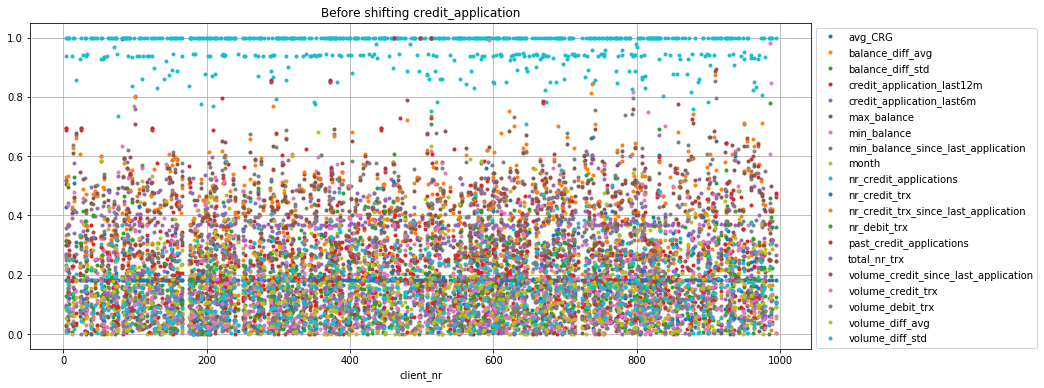

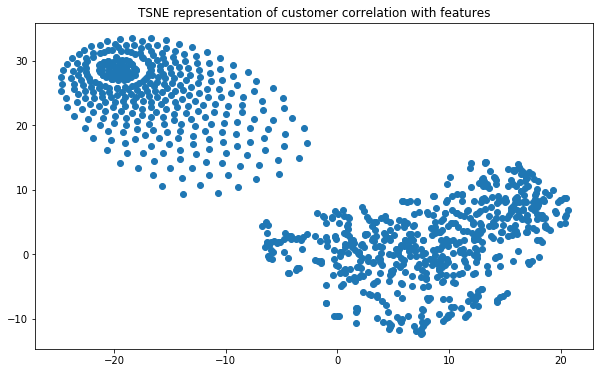

In [4]:
corr_df_pre.clean()
corr_df_pre.plot_correlation(min_agg_corr=0.5, title='Before shifting credit_application')
corr_df_pre.plot_tsne()

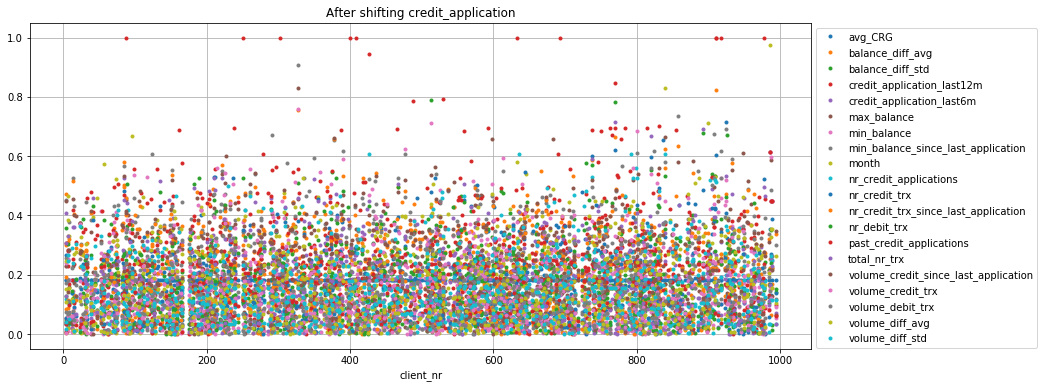

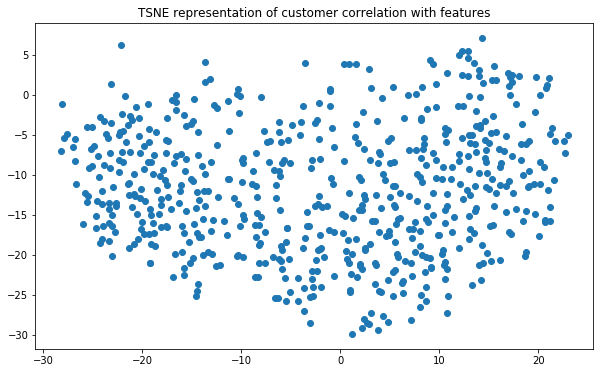

,avg_CRG,balance_diff_avg,balance_diff_std,credit_application_last12m,credit_application_last6m,max_balance,min_balance,min_balance_since_last_application,month,nr_credit_applications,nr_credit_trx,nr_credit_trx_since_last_application,nr_debit_trx,past_credit_applications,total_nr_trx,volume_credit_since_last_application,volume_credit_trx,volume_debit_trx,volume_diff_avg,volume_diff_std
client_nr,,,,,,,,,,,,,,,,,,,,
984,0.182033,0.169295,0.105408,0.132453,0.097590,0.124735,0.085316,0.337644,0.214491,0.033333,0.058963,0.322253,0.215293,0.080064,0.110789,0.311605,0.209324,0.193147,0.206371,0.007206
986,0.353553,0.252095,0.164082,0.612372,0.612372,0.162679,0.147632,0.223973,0.163015,0.116569,0.169071,0.224197,0.164708,0.612372,0.166584,0.216107,0.151190,0.146916,0.974529,0.033226
987,0.130931,0.062975,0.350815,0.447214,0.447214,0.586910,0.120488,0.223973,0.353553,0.250000,0.269196,0.224197,0.239285,0.447214,0.257260,0.216107,0.598564,0.484356,0.328624,0.264289
989,0.182033,0.169630,0.013151,0.447214,0.447214,0.129080,0.246167,0.223973,0.353553,0.250000,0.386962,0.224197,0.031563,0.447214,0.229093,0.216107,0.153999,0.262066,0.156750,0.113424
994,0.182033,0.063695,0.142353,0.096374,0.072232,0.063104,0.055588,0.300955,0.105487,0.033333,0.138447,0.338675,0.150575,0.059761,0.032382,0.348026,0.089970,0.117935,0.264831,0.115309


In [5]:
corr_df_post.clean()
corr_df_post.plot_correlation(min_agg_corr=0.5, title='After shifting credit_application')
corr_df_post.plot_tsne()
corr_df_post.tail()

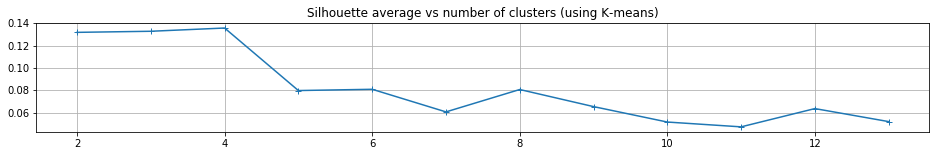

Optimum number of clusters is 4


,avg_CRG,balance_diff_avg,balance_diff_std,credit_application_last12m,credit_application_last6m,max_balance,min_balance,min_balance_since_last_application,month,nr_credit_applications,...,nr_credit_trx_since_last_application,nr_debit_trx,past_credit_applications,total_nr_trx,volume_credit_since_last_application,volume_credit_trx,volume_debit_trx,volume_diff_avg,volume_diff_std,cluster
client_nr,,,,,,,,,,,,,,,,,,,,,
984,0.182033,0.169295,0.105408,0.132453,0.097590,0.124735,0.085316,0.337644,0.214491,0.033333,...,0.322253,0.215293,0.080064,0.110789,0.311605,0.209324,0.193147,0.206371,0.007206,0
986,0.353553,0.252095,0.164082,0.612372,0.612372,0.162679,0.147632,0.223973,0.163015,0.116569,...,0.224197,0.164708,0.612372,0.166584,0.216107,0.151190,0.146916,0.974529,0.033226,3
987,0.130931,0.062975,0.350815,0.447214,0.447214,0.586910,0.120488,0.223973,0.353553,0.250000,...,0.224197,0.239285,0.447214,0.257260,0.216107,0.598564,0.484356,0.328624,0.264289,2
989,0.182033,0.169630,0.013151,0.447214,0.447214,0.129080,0.246167,0.223973,0.353553,0.250000,...,0.224197,0.031563,0.447214,0.229093,0.216107,0.153999,0.262066,0.156750,0.113424,3
994,0.182033,0.063695,0.142353,0.096374,0.072232,0.063104,0.055588,0.300955,0.105487,0.033333,...,0.338675,0.150575,0.059761,0.032382,0.348026,0.089970,0.117935,0.264831,0.115309,0


In [6]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

MIN_CLUSTERS = 2
MAX_CLUSTERS = 14
clust_dict = {k:0 for k in range(MIN_CLUSTERS, MAX_CLUSTERS)}
for k in clust_dict.keys():
    clf = KMeans(n_clusters=k)
    klabels = clf.fit_predict(corr_df_post.fillna(0))
    clust_dict[k] = silhouette_score(corr_df_post.fillna(0), klabels)
plt.figure(figsize=(16,2))
plt.plot(list(clust_dict.keys()), list(clust_dict.values()), '+-')
plt.grid()
plt.title('Silhouette average vs number of clusters (using K-means)')
plt.show()

best_num_groups = list(clust_dict.keys())[np.argmax(list(clust_dict.values()))]
print("Optimum number of clusters is {}".format(best_num_groups))
clf = KMeans(n_clusters=best_num_groups)
klabels = clf.fit_predict(corr_df_post.fillna(0))
corr_df_post['cluster'] = klabels
corr_df_post.tail()

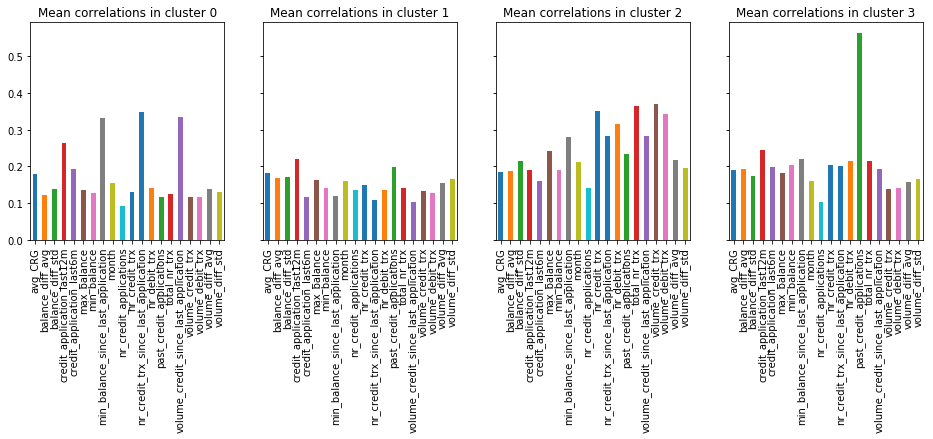

Number of customers within cluster
cluster
0    221
1    254
2     61
3     68
Name: month, dtype: int64
Total customers not belonging to any cluster: 388 (39.113%)


In [7]:
f, axarr = plt.subplots(1, len(corr_df_post.cluster.unique()), sharey=True, figsize=(16,4))
for c in corr_df_post.cluster.unique():
    corr_df_post.loc[corr_df_post['cluster']==c, [x for x in corr_df_post.columns if x!= 'cluster']].mean().plot(kind='bar', ax=axarr[c])
    axarr[c].set_title("Mean correlations in cluster {}".format(c))
plt.show()
print("Number of customers within cluster")
print(corr_df_post.groupby('cluster').count()['month'])
total_clients = len(df.client_nr.unique())
assigned_clients = corr_df_post.cluster.count()
print("Total customers not belonging to any cluster: {} ({:.3f}%)".format(total_clients - assigned_clients, 100-100*assigned_clients/total_clients))

In [8]:
df =  df.merge(corr_df_post.reset_index()[['client_nr', 'cluster']], on='client_nr')
print("Number of customer records on each cluster")
df.groupby('cluster').count()['client_nr']

Number of customer records on each cluster


cluster
0    6851
1    7874
2    1891
3    2108
Name: client_nr, dtype: int64

# Predictions

## Configuration of the predictions

The following parameters drive the configuration of the predictions.

In [9]:
# configuration context variables
exclude = ['yearmonth', 'credit_application', 'cluster', 'client_nr']  # parameters that should not be accounted for in train data
predict_what = 'credit_application'
scale = True  # whether to scale the features so they all are in a similar interval (-1, 1)
fill_nan = False # for missing data, sets the feature to zero as default (something more clever could be done)
on_future = True  # train-test split is based on past-future and not randomly
split_date=dt.datetime(2016, 3, 1)  # date where the train set stop and test set begins
split_size=0.8  # when not using on_future, random % of train and test data

## Module support functions

The following functions would typically go on a module but are left in the notebook for clarity.

The data processing and test-train split is done through a test class without altering context.

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

get_x = lambda df: df[[x for x in df.columns if x not in exclude]]
get_y = lambda df: df[predict_what].astype(bool).astype(int)

def train_test_split_date(df, date):
    """ 
    Splits based on the past (train) and the future (test) of date. 
    Closest to real business life
    """
    return df[df.yearmonth <= date], df[df.yearmonth > date]


def pretty_confusion_matrix(true_y, pred_y):
    """
    Provides the confusion matrix with printed axis
    """
    if type(pred_y[0]) != bool or type(pred_y[0]) != int:
        pred_y = np.round(pred_y).astype(int)
    pcf = pd.DataFrame(columns=pd.MultiIndex.from_product([['Predicted'], [False, True]]), 
                       index=pd.MultiIndex.from_product([['Actual'], [False, True]]), 
                       data=confusion_matrix(true_y, pred_y))
    return pcf


def get_train_test(df):
    """
    Automates the pre-processing and train and test data split
    """
    df_copy = df.copy()  # shallow copy in order not to alter info on reference area
    if fill_nan:
        df_copy.fillna(0, inplace=True)
    else:
        df_copy.dropna(inplace=True)

    if scale:
        scaler = StandardScaler()
        scaler.fit(get_x(df_copy))
        df_copy.loc[get_x(df_copy).index, get_x(df_copy).columns] = scaler.transform(get_x(df_copy))

    if on_future:
        train_data, test_data = train_test_split_date(df_copy, split_date)
    else:
        train_data, test_data = train_test_split(df, train_size=split_size)
    print("Train data size = {}".format(train_data.shape))
    print("Test data size = {}".format(test_data.shape))
    return train_data, test_data


class TestClassifier():
    """
    Class that encapsulates a test on a given classifier
    """
    def __init__(self, df):
        self.train_data, self.test_data = get_train_test(df)
    
    def benchmark(self, clf, what='train'):
        which_data = self.train_data if what == 'train' else self.test_data
        try:
            predict_y = clf.predict(get_x(which_data))
            print(pretty_confusion_matrix(get_y(which_data), predict_y))
        except ValueError:
            print("Not enough data to evaluate {} prediction".format(what))

    def fit_benchmark(self, clf, **kwargs):
        """
        Uses scope train_data and test_data to fit and benchmark
        """
        # classifier will be updated in reference area, so it is available afterwards
        clf.fit(get_x(self.train_data), get_y(self.train_data), **kwargs)
        print("Model performance on train dataset")
        self.benchmark(clf, what='train')
        print("Model performance on test dataset")
        self.benchmark(clf, what='test')

## Prediction

Given the nature of the problem, a confusion matrix is the best metric to understand what is going on:

* Actual=0, Predicted=0: this is a True Negative (TN). This basically means that we have predicted that this customer over that month is not interesting and it wasn't.
* Actual=1, Predicted=1: this is a True Positive (TP). This basically means that we have predicted that this customer over that month would ask for a loan and it did.
* Actual=1, Predicted=0: this is a False Negative (FN). This basically means that we have predicted that this customer over that month is not interesting but it actually asked for a loan.
* Actual=0, Predicted=1: this is a False Positive (FP). This basically means that we have predicted that this customer over that month would ask for a loan and it didn't.

Moreover in this case, the recall (the capacity to not miss people asking for a loan) is a more interesting score rather than precision (the art of not engaging a customer when it is not interested) as there is more business loss in the former.

### Logistic regression

This is the most simple algorithm that has also the advantadge of knowing how the algorithm is actually coping with the weight assignation.

Train data size = (8472, 25)
Test data size = (2104, 25)
Model performance on train dataset
             Predicted      
                 False True 
Actual False      7500     2
       True        969     1
Model performance on test dataset
             Predicted      
                 False True 
Actual False      1898     0
       True        206     0


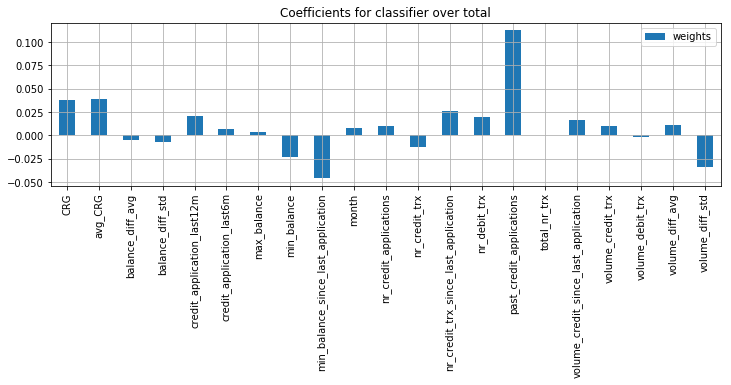


**Training and benchmarking customers in cluster 0**
Train data size = (3097, 25)
Test data size = (769, 25)
Model performance on train dataset
             Predicted      
                 False True 
Actual False      2737     3
       True        356     1
Model performance on test dataset
             Predicted      
                 False True 
Actual False       669     5
       True         92     3


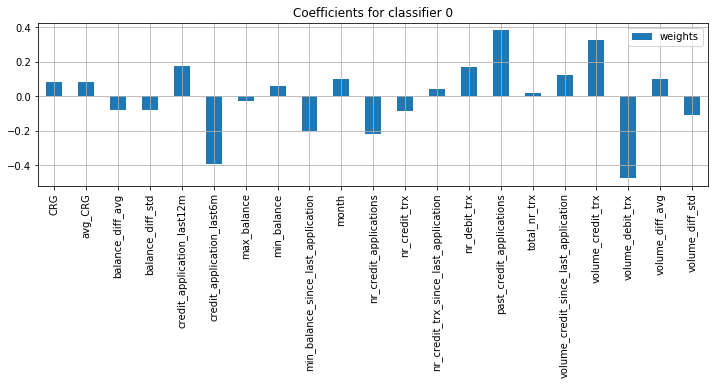


**Training and benchmarking customers in cluster 2**
Train data size = (765, 25)
Test data size = (197, 25)
Model performance on train dataset
             Predicted      
                 False True 
Actual False       685     2
       True         75     3
Model performance on test dataset
             Predicted      
                 False True 
Actual False       176     3
       True         18     0


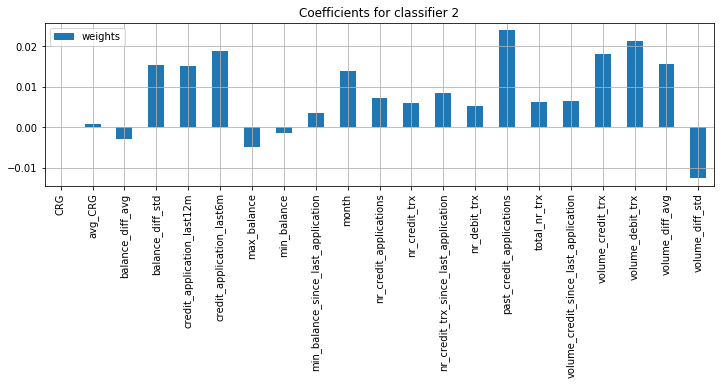


**Training and benchmarking customers in cluster 1**
Train data size = (3695, 25)
Test data size = (913, 25)
Model performance on train dataset
             Predicted      
                 False True 
Actual False      3180     4
       True        511     0
Model performance on test dataset
             Predicted      
                 False True 
Actual False       828     1
       True         84     0


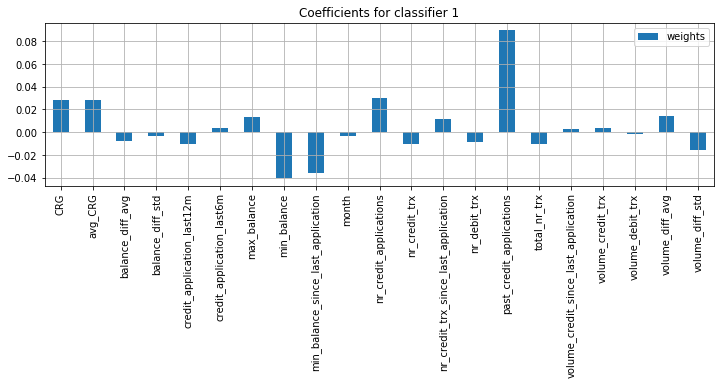


**Training and benchmarking customers in cluster 3**
Train data size = (915, 25)
Test data size = (225, 25)
Model performance on train dataset
             Predicted      
                 False True 
Actual False       891     0
       True         23     1
Model performance on test dataset
             Predicted      
                 False True 
Actual False       216     0
       True          9     0


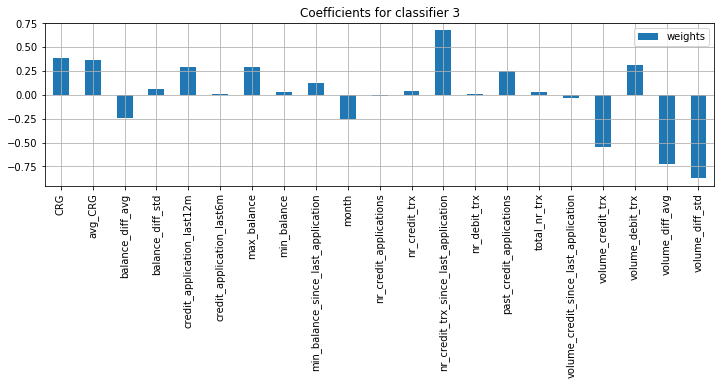

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, make_scorer

def show_coefs (clf, clf_name=''):
    pd.DataFrame(columns=get_x(df).columns, index=['weights'], data=clf.coef_ ).transpose().plot(kind='bar', figsize=(12,3))
    plt.title('Coefficients for classifier {}'.format(clf_name))
    plt.grid()
    plt.show()

tc = TestClassifier(df)
clf = LogisticRegression()
gs = GridSearchCV(clf, {'C':[1e-3, 1e-2, 1e-1, 1, 10]}, scoring=make_scorer(recall_score))
tc.fit_benchmark(gs)
show_coefs(gs.best_estimator_, clf_name='over total')

for c in df.cluster.unique():
    print("")
    print("**Training and benchmarking customers in cluster {}**".format(c))
    tc = TestClassifier(df[df.cluster==c])
    clf = LogisticRegression()
    gs = GridSearchCV(clf, {'C':[1e-3, 1e-2, 1e-1, 1, 10]}, scoring=make_scorer(recall_score))
    tc.fit_benchmark(gs)
    show_coefs(gs.best_estimator_, clf_name=str(c))

### Support Vector Machine

When using a SVM we see that we almost fit the training set (precision and recall ~1) but we fail miserably at predicting the new dataset since we basically classify everything as 0. 
This is an example of overfitting that could be helped by using regularization or by using a different classifier that is less prone to overfitting.

In [12]:
from sklearn.svm import SVC

tc = TestClassifier(df)
clf = SVC(C=1)
tc.fit_benchmark(clf)

# by clusters
for c in df.cluster.unique():
    print("")
    print("**Training and benchmarking customers in cluster {}**".format(c))
    tc = TestClassifier(df[df.cluster==c])
    clf = SVC(C=1)
    tc.fit_benchmark(clf)

Train data size = (8472, 25)
Test data size = (2104, 25)
Model performance on train dataset
             Predicted      
                 False True 
Actual False      7502     0
       True        965     5
Model performance on test dataset
             Predicted      
                 False True 
Actual False      1898     0
       True        206     0

**Training and benchmarking customers in cluster 0**
Train data size = (3097, 25)
Test data size = (769, 25)
Model performance on train dataset
             Predicted      
                 False True 
Actual False      2740     0
       True        355     2
Model performance on test dataset
             Predicted      
                 False True 
Actual False       674     0
       True         95     0

**Training and benchmarking customers in cluster 2**
Train data size = (765, 25)
Test data size = (197, 25)
Model performance on train dataset
             Predicted      
                 False True 
Actual False       687     0


### Random forests

In [13]:
from sklearn.ensemble import RandomForestClassifier

tc = TestClassifier(df)
clf = RandomForestClassifier()
tc.fit_benchmark(clf)

for c in df.cluster.unique():
    print("")
    print("**Training and benchmarking customers in cluster {}**".format(c))
    tc = TestClassifier(df[df.cluster==c])
    clf = RandomForestClassifier()
    tc.fit_benchmark(clf)

Train data size = (8472, 25)
Test data size = (2104, 25)
Model performance on train dataset
             Predicted      
                 False True 
Actual False      7501     1
       True        177   793
Model performance on test dataset
             Predicted      
                 False True 
Actual False      1873    25
       True        201     5

**Training and benchmarking customers in cluster 0**
Train data size = (3097, 25)
Test data size = (769, 25)
Model performance on train dataset
             Predicted      
                 False True 
Actual False      2740     0
       True         57   300
Model performance on test dataset
             Predicted      
                 False True 
Actual False       659    15
       True         84    11

**Training and benchmarking customers in cluster 2**
Train data size = (765, 25)
Test data size = (197, 25)
Model performance on train dataset
             Predicted      
                 False True 
Actual False       687     0


In [14]:
from sklearn.tree import export_graphviz
import pydot

clf.estimators_[0]
export_graphviz(clf.estimators_[0], feature_names=get_x(df).columns, out_file='tree.dot')
graph, = pydot.graph_from_dot_file('tree.dot')
graph.write_png('tree.png')

Next we will use a Random Forest classifier but we will perform a Grid Search over hyperparameters to maximize recall. This is an expensive calculation as we will iterate over all the permutations of hyperparameters in the input dictionaries but allows for an automated search of the best solution.

In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, make_scorer

tc = TestClassifier(df)
clf = RandomForestClassifier()
gs = GridSearchCV(clf, 
                  {'max_features':list(range(5,len(get_x(df).columns))), 
                   'min_samples_split':[2,3,4, 5, 6]},
                  scoring=make_scorer(recall_score))
tc.fit_benchmark(gs)
print("Best score is: {} with estimator".format(gs.best_score_))
gs.best_estimator_

Train data size = (8472, 25)
Test data size = (2104, 25)
Model performance on train dataset
             Predicted      
                 False True 
Actual False      7498     4
       True        258   712
Model performance on test dataset
             Predicted      
                 False True 
Actual False      1839    59
       True        197     9
Best score is: 0.06287575635812918 with estimator


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=11, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=6, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

### Neural network classification

Trying out a NN for classification results (even with grid-searching the regularization parameter) in an absolute 0 recall, for that given architecture.

In [16]:
from sklearn.neural_network import MLPClassifier

tc = TestClassifier(df)
clf = MLPClassifier (hidden_layer_sizes=[10, 24], alpha=1)
gs = GridSearchCV(clf, 
                  {'alpha':[1e-4, 1e-2, 1, 10, 100]}, 
                  scoring=make_scorer(recall_score))
tc.fit_benchmark(gs)
print("Best score is: {} with estimator".format(gs.best_score_))
gs.best_estimator_

Train data size = (8472, 25)
Test data size = (2104, 25)
Model performance on train dataset
             Predicted      
                 False True 
Actual False      7501     1
       True        961     9
Model performance on test dataset
             Predicted      
                 False True 
Actual False      1891     7
       True        205     1
Best score is: 0.011346267481879868 with estimator


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=[10, 24], learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

# TODO: next steps

Basically there were two limiting factors on my analysis:
* 1) Lack of business knowledge
* 2) Time

If possible I would then follow this roadmap to come up with a good predictive model.

* Talk to the business people to understand what makes a certain customer go for a loan and model that in the features.
* Pre-process the customer pool into clusters based on different features (e.g. size, regularity...) and then train a model for each cluster.
* Come up with a good policy for missing data, for example, discarding or interpolating over the gaps.
* Use polynomial features.
* Explode the datasize (more months or more customers, or both) and prevent overfitting by just throwing loads of data to a complex model. For this maybe another framework would be needed such as Apache-Spark.
* Predict not only the likelihood of classification but also the number of times someone might ask for a loan every month.
* Make the prediction lighter by using PCA or another dimensionality reduction technique